# Arxiv Paper Classification

## Introduction

Every year, thousands of academic papers are published worldwide. A big component of research is keeping up to date with papers for established and aspiring researchers alike. ...

## Data exploration

In [1]:
from dataloader import ArxivData
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
data = ArxivData("data/2018.tar.gz")

The data consists of metadata for all arxiv papers published in 2018. What we'd like to do is given the title and abstract of a research paper, predict what primary category/field it belongs to.

Looking at the data below, we're interested in the primary category, categories, title, and abstract.

In [3]:
df = data._read_tar()
df.head()

,Unnamed: 0,abstract,acm_class,arxiv_id,author_text,categories,comments,created,doi,num_authors,num_categories,primary_cat,title,updated,created_ym
0,1037394,There are many practical applications based on...,NaN,1802.07591,Vaclav Skala,"cs.GR,cs.CV",NaN,2018-01-01,10.15439/978-83-946253-7-5,1,2,cs.GR,Least Square Error Method Robustness of Comput...,NaN,2018-01
1,318945,We describe the operation of an electrodynamic...,NaN,1801.00424,"C. J. Foot, D. Trypogeorgos, E. Bentine, A. Ga...","physics.ins-det,physics.atom-ph","12 pages, 7 figures",2018-01-01,10.1016/j.ijms.2018.05.007,5,2,physics.ins-det,Two-frequency operation of a Paul trap to opti...,NaN,2018-01
2,982758,The relevance of magnetic impurity problems in...,NaN,1801.00482,"Igor Kuzmenko, Tanya Kuzmenko, Yshai Avishai","cond-mat.quant-gas,cond-mat.str-el,physics.ato...","6 pages, 3 eps figures",2018-01-01,NaN,3,3,cond-mat.quant-gas,Optical Control of Exchange Interaction and Ko...,2018-09-21,2018-01
3,178551,Unsupervised video summarization plays an impo...,NaN,1801.00543,"Yujia Zhang, Xiaodan Liang, Dingwen Zhang, Min...",cs.CV,NaN,2018-01-01,NaN,5,1,cs.CV,Unsupervised Object-Level Video Summarization ...,2018-08-11,2018-01
4,368903,It is shown that acceleration of particles in ...,NaN,1801.00447,M. A. Kutlan,physics.acc-ph,12 pages,2018-01-01,NaN,1,1,physics.acc-ph,Acceleration in a Periodic Magnetic Field,NaN,2018-01


There are a lot of arxiv paper [categories](https://arxiv.org/help/prep#subj), and unfortunately they are not all published at the same rate as we can see from the plot below. Because of this, it makes sense to use some number of the most frequently published papers in a muticlass classification problem.

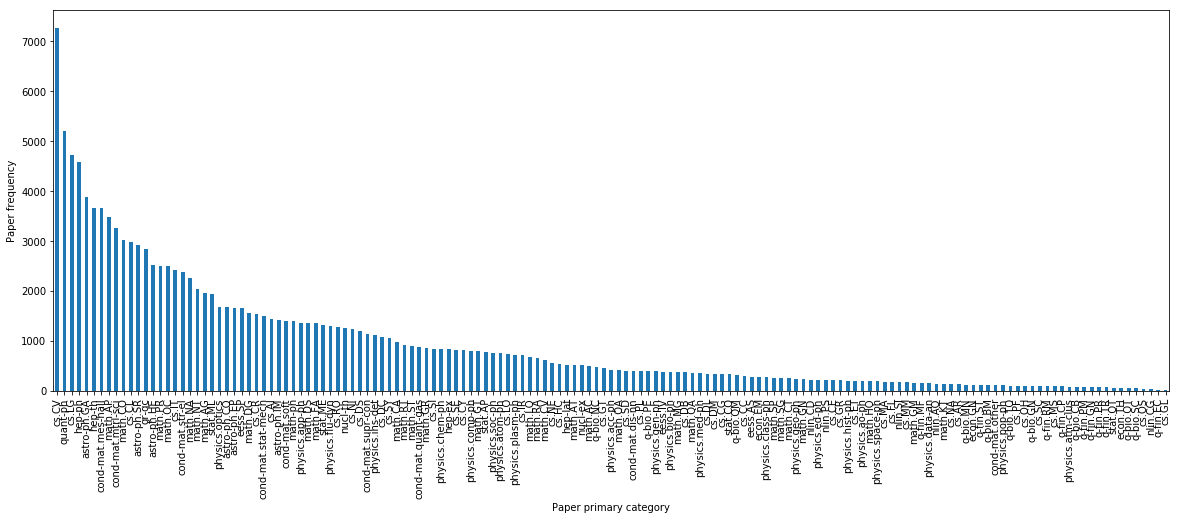

In [4]:
plt.figure(figsize=(20, 7))
df.primary_cat.value_counts().plot('bar')
plt.ylabel('Paper frequency')
plt.xlabel('Paper primary category')
plt.show()

Let's look at the top 10 most frequent main paper tags.

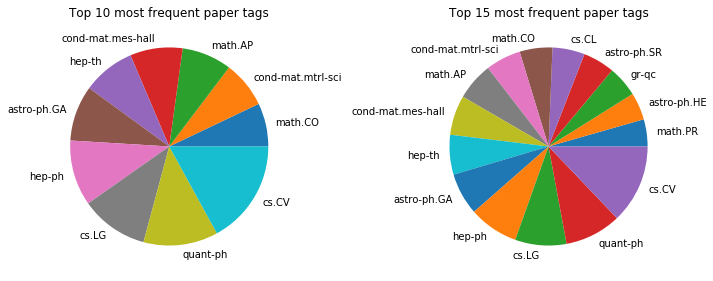

In [5]:
f, axarr = plt.subplots(1, 2, figsize=(10, 10))

top10_df = data._process_dataframe(df, num_classes=10)
axarr[0].pie(data.classes, labels=data.classes.axes[0].tolist())
axarr[0].set_title('Top 10 most frequent paper tags')

top15_df = data._process_dataframe(df, num_classes=15)
axarr[1].pie(data.classes, labels=data.classes.axes[0].tolist())
axarr[1].set_title('Top 15 most frequent paper tags')

f.tight_layout()
plt.show()

For simplicity, we will use the top 10 classes for the rest of this analysis.

In [6]:
# This just combines the previous steps into a single method.
data._get_data(num_classes=10)

## Logistic Regression

We're going to try a number of techniques to solve this problem, but let's start simple first. A multi-class logistic regression classifier will give us a baseline and let us interpret some word features from each tag. We can also use this step to explore what kinds of features we should use.

In [7]:
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

### Bag of Words (BoW)

Let's start with a simple bag of words model. Scikit-learn's CountVectorizer lets us easily convert our training sentences into a matrix of counts.

In [9]:
data.bow = CountVectorizer()
data.trainX_bow = data.bow.fit_transform(data.train_data)

Just to understand what this actually doing, let's take the first row of the matrix we just created. It represents the bag of words vector for the first document in our dataset. Keep in mind that a document in this context refers to a paper's title and abstract concatenated to each other.

In [35]:
print("Our document: ", data.train_data[0])
print()
bow_arr = data.trainX_bow[0].toarray()[0]
bow_nonzero = [bow_arr[i] for i in np.nonzero(bow_arr)][0]
print("Bag of words representation: {}, length: {}".format(bow_arr, len(bow_arr)))
print("Some nonzero entries: {}".format(bow_nonzero))
print("Sum of values in BoW vector:", sum(bow_arr))
print("Number of whitespace separated tokens:", len(data.train_data[0].split(' ')))

Our document:  Unsupervised Object-Level Video Summarization with Online Motion Auto-Encoder. Unsupervised video summarization plays an important role on digesting, browsing, and searching the ever-growing videos every day, and the underlying fine-grained semantic and motion information (i.e., objects of interest and their key motions) in online videos has been barely touched. In this paper, we investigate a pioneer research direction towards the fine-grained unsupervised object-level video summarization. It can be distinguished from existing pipelines in two aspects: extracting key motions of participated objects, and learning to summarize in an unsupervised and online manner. To achieve this goal, we propose a novel online motion Auto-Encoder (online motion-AE) framework that functions on the super-segmented object motion clips. Comprehensive experiments on a newly-collected surveillance dataset and public datasets have demonstrated the effectiveness of our proposed method. 

Bag of 

The bag of words representation vector isn't really notable but from the sum of the vector, we see that there are 136 words in the sentence we provided. However, we also see that there are 131 whitespace separated tokens in the string we provided. Does this mean there are 131 words or 136?

This is the basis for word tokenization: what actually constitutes a word? The answer is, it depends on the type of data that you encounter but even then, can be subjective. For example, is 'New York' two words or one? This is a pretty important topic in NLP but we won't be exploring it much further besides what is provided to us in scikit-learn.

Scikit-learn does its own word tokenization that includes converting all characters to lowercase, removing hyphens and other special symbols, etc.

In [36]:
bow_features = data.bow.inverse_transform(data.trainX_bow[0])[0]
print(bow_features)

['method' 'proposed' 'our' 'effectiveness' 'demonstrated' 'have'
 'datasets' 'public' 'dataset' 'surveillance' 'collected' 'newly'
 'experiments' 'comprehensive' 'clips' 'segmented' 'super' 'functions'
 'that' 'framework' 'ae' 'novel' 'propose' 'goal' 'achieve' 'manner'
 'summarize' 'to' 'learning' 'participated' 'extracting' 'aspects' 'two'
 'pipelines' 'existing' 'from' 'distinguished' 'be' 'can' 'it' 'towards'
 'direction' 'research' 'pioneer' 'investigate' 'we' 'paper' 'this'
 'touched' 'barely' 'been' 'has' 'in' 'motions' 'key' 'their' 'interest'
 'of' 'objects' 'information' 'semantic' 'grained' 'fine' 'underlying'
 'day' 'every' 'videos' 'growing' 'ever' 'the' 'searching' 'and'
 'browsing' 'digesting' 'on' 'role' 'important' 'an' 'plays' 'encoder'
 'auto' 'motion' 'online' 'with' 'summarization' 'video' 'level' 'object'
 'unsupervised']


What we are doing above is giving scikit-learn the bag of words vector and ask asking for what features are in our original document. We see that the bag of words model essentially removes any sort of context that we had in the original document, but the upside is that we now have a vector representation of the document that ML models can work with.

## Term Frequency Inverse Document Frequency Weighting (TF-IDF)

Another issue with bag of words is that it assigns equal weight to words that don't provide much meaning to document. 'How much meaning a word provides' is pretty subjective, but term frequency inverse document frequency (TF-IDF) is one way to measure this. For each word, it compares how often that word occurs in one document compared to all other documents. 

tf-idf(word in doc 1) = $\frac{\text{frequency of word in doc 1}}{\text{frequency of word across all docs}}$

This gives a very low weight to words like 'the' that appear frequently, but also appear frequently in other documents. This weighting is also normalized, so unlike bag of words, vectors can only contain values in [0, 1]. We see this in the example below, where the sum of the vector can no longer be interpreted as the number of words that are in the sentence.

In [18]:
data.tfidf = TfidfVectorizer()
data.trainX_tfidf = data.tfidf.fit_transform(data.train_data)

In [20]:
tfidf_arr = data.trainX_tfidf[0].toarray()[0]
tfidf_nonzero = [tfidf_arr[i] for i in np.nonzero(tfidf_arr)][0]
print("tf-idf representation:", tfidf_arr)
print("Some nonzero entries: {}".format(tfidf_nonzero))
print("Sum of values in tf-idf vector:", sum(tfidf_arr))

tf-idf representation: [0. 0. 0. ... 0. 0. 0.]
Some nonzero entries: [0.05605718 0.10933456 0.04588338 0.09966868 0.07140467 0.17141049
 0.11160432 0.02469972 0.03994757 0.1271632  0.02629592 0.10986745
 0.0769458  0.07216244 0.05117691 0.04982879 0.0835846  0.06343981
 0.14418445 0.06381951 0.09231331 0.06374636 0.15705611 0.0881092
 0.06224571 0.05061041 0.04455088 0.08260015 0.13369355 0.04557419
 0.02439919 0.05073583 0.06911028 0.16520031 0.07733681 0.03499616
 0.03341686 0.04934637 0.05753664 0.04410107 0.06143738 0.04900933
 0.03077565 0.11168285 0.03867101 0.09605686 0.06892213 0.03739097
 0.29613467 0.16063832 0.07942299 0.04493364 0.17218403 0.11665763
 0.04122041 0.05768757 0.36446645 0.02726331 0.03338755 0.12925764
 0.12534891 0.09797248 0.07389469 0.03800221 0.04037179 0.076707
 0.0601606  0.05590272 0.08456133 0.09201792 0.06528981 0.30943808
 0.09512301 0.06930108 0.08925163 0.01776121 0.06838187 0.03784409
 0.03863249 0.0299266  0.13173483 0.05843943 0.03020928 0.06312

Let's see how these counts compare to the bag of words representation by looking at the top 10 largest word counts in each vector. Arguably abstracts and titles are very information dense and so the advantage that we get in using TF-IDF weighting may be slight. But it's still good to know that we aren't heavily weighting words like 'and' and 'in' like we see in the bag of words plot.

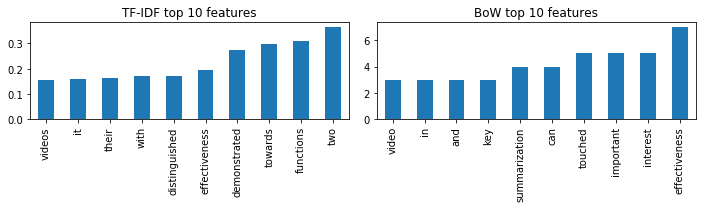

In [45]:
f, axarr = plt.subplots(1, 2, figsize=(10, 3))

tfidf_features = data.tfidf.inverse_transform(data.trainX_tfidf[0])[0]
tfidf_counts = pd.Series(tfidf_nonzero, tfidf_features).sort_values()
tfidf_counts[-10:].plot('bar', ax=axarr[0])
axarr[0].set_title('TF-IDF top 10 features')

bow_counts = pd.Series(bow_nonzero, bow_features).sort_values()
bow_counts[-10:].plot('bar', ax=axarr[1])
axarr[1].set_title('BoW top 10 features')

plt.tight_layout()
plt.show()